In [32]:
%matplotlib inline

In [33]:
#Imports:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import random

# PSO TVAC Treasure Hunt 🪙

Ovaj projekat simulira potragu za blagom pomoću **Particle Swarm Optimization (PSO)** algoritma sa **Time-Varying Acceleration Coefficients (TVAC)** pristupom.

U ovoj simulaciji, čestice predstavljaju istraživače koji pokušavaju da pronađu **blago** skriveno u velikoj numeričkoj "pustinji".  
Pustinja je predstavljena **Schwefel funkcijom**, poznatom po svom haotičnom pejzažu punom lokalnih minimuma, koji otežavaju pronalaženje pravog cilja.

---

### 🗺️ Mapa pustinje (Schwefel funkcija)

Schwefel funkcija se često koristi za testiranje optimizacionih algoritama jer sadrži **mnoštvo lokalnih minimuma** i samo **jedan globalni minimum** u tački  
`(420.9687, 420.9687)` sa vrednošću `f(x, y) = 0`.

U kontekstu igre:
- visoke vrednosti `Z` predstavljaju **brda i prepreke**,  
- niske vrednosti predstavljaju **dolinu** u kojoj se krije blago.

U sledećoj ćeliji se prikazuje 3D vizuelizacija terena koji čestice treba da istraže.


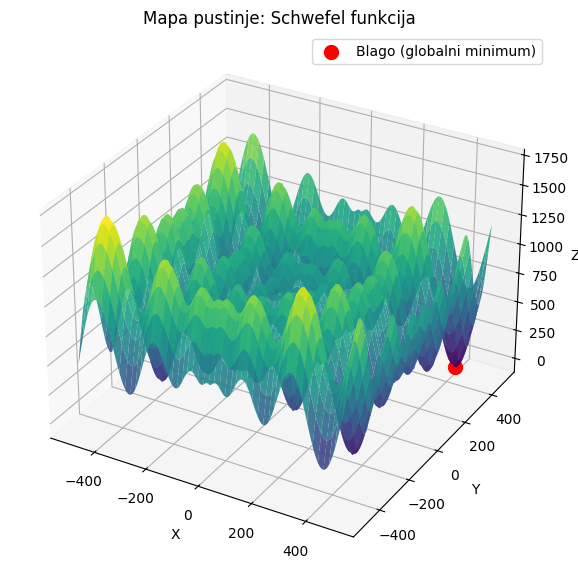

In [34]:
# Vizuelizacija "pustinje" pomoću Schwefel funkcije

def schwefel_2d(x, y):
    """
    Schwefel funkcija 2D:
    f(x, y) = 418.9829*2 - x*sin(sqrt(|x|)) - y*sin(sqrt(|y|))
    Globalni minimum: (420.9687, 420.9687), vrednost = 0
    """
    return 418.9829*2 - x*np.sin(np.sqrt(np.abs(x))) - y*np.sin(np.sqrt(np.abs(y)))

# Kreiranje mreže
x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)

# 3D prikaz funkcije
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)

# Obeležavanje globalnog minimuma
ax.scatter(420.9687, 420.9687, 0, color='red', s=100, label='Blago (globalni minimum)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Mapa pustinje: Schwefel funkcija')
ax.legend()
plt.show()


## Osnovni PSO algoritam

U ovoj sekciji definišemo osnovnu Particle klasu i PSO funkciju koja će iterativno pomerati čestice po mapi pustinje (Schwefel funkcija) ka globalnom minimumu.

In [35]:
class Particle_default:
    def __init__(self, bounds, f):
        self.lower_bounds = bounds[:, 0]
        self.upper_bounds = bounds[:, 1]
        self.position = np.random.uniform(self.lower_bounds, self.upper_bounds)
        self.velocity = np.random.uniform(-1, 1, size=len(bounds))
        self.f = f

        # Evaluacija funkcije
        self.value = self.f(self.position[0], self.position[1])
        self.personal_best_position = self.position.copy()
        self.personal_best_value = self.value

    def update_velocity(self, global_best_position, w=0.7, c1=1.5, c2=1.5):
        r1 = np.random.rand(len(self.position))
        r2 = np.random.rand(len(self.position))
        cognitive = c1 * r1 * (self.personal_best_position - self.position)
        social = c2 * r2 * (global_best_position - self.position)
        self.velocity = w * self.velocity + cognitive + social

    def move(self):
        self.position = np.clip(self.position + self.velocity, self.lower_bounds, self.upper_bounds)
        self.value = self.f(self.position[0], self.position[1])
        if self.value < self.personal_best_value:
            self.personal_best_position = self.position.copy()
            self.personal_best_value = self.value


In [36]:
def pso(f, bounds, swarm_size=30, num_iters=100, w=0.7, c1=1.5, c2=1.5):
    swarm = [Particle_default(bounds, f) for _ in range(swarm_size)]
    global_best_position = swarm[0].personal_best_position.copy()
    global_best_value = swarm[0].personal_best_value

    history = []

    for _ in range(num_iters):
        for p in swarm:
            p.update_velocity(global_best_position, w, c1, c2)
            p.move()

            if p.personal_best_value < global_best_value:
                global_best_position = p.personal_best_position.copy()
                global_best_value = p.personal_best_value

        history.append(global_best_value)

    return global_best_position, global_best_value, history


In [37]:
def convergence_speed(history):
    """Računa prosečan pad funkcije po iteraciji."""
    if len(history) < 2:
        return 0.0
    
    # Uzimamo samo deo gde se realno dešava konvergencija (druga polovina)
    start_val = np.mean(history[:len(history)//2])
    end_val = np.mean(history[-len(history)//4:])
    
    avg_speed = (start_val - end_val) / (len(history)//2)
    return avg_speed

Najbolja pozicija: [-302.52491113  420.96872404]
Vrednost na toj poziciji: 118.43836006970918
Brzina konvergencije (PSO): 0.2309


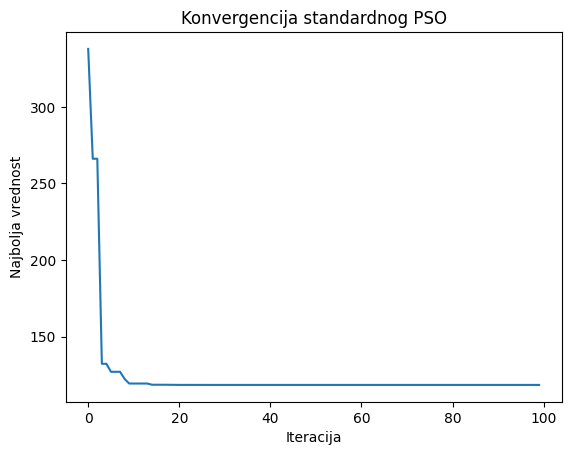

In [71]:
import matplotlib.pyplot as plt

# Definisanje granica (npr. 2D Schwefel)
bounds = np.array([[-500, 500], [-500, 500]])

# Pokretanje standardnog PSO
best_pos, best_val, history = pso(schwefel_2d, bounds, swarm_size=30, num_iters=100)

print("Najbolja pozicija:", best_pos)
print("Vrednost na toj poziciji:", best_val)
speed_pso = convergence_speed(history)
print(f"Brzina konvergencije (PSO): {speed_pso:.4f}")

# Grafikon konvergencije
plt.plot(history)
plt.xlabel("Iteracija")
plt.ylabel("Najbolja vrednost")
plt.title("Konvergencija standardnog PSO")
plt.show()


## PSO with TVAC

**Napomena o TVAC modelu:**  

Koeficijenti inercije, socijalnog i kognitivnog dela se menjaju tokom iteracija linearnom funkcijom, što je standardni model poznat kao *Time Varying Acceleration Coefficients* (TVAC).  

Ovaj pristup je opisan u:  
Y. Shi and R. Eberhart, "A modified particle swarm optimizer," 1998 IEEE International Conference on Evolutionary Computation Proceedings. IEEE World Congress on Computational Intelligence (Cat. No.98TH8360), Anchorage, AK, USA, 1998, pp. 69-73, doi: 10.1109/ICEC.1998.699146. keywords: {Particle swarm optimization;Nonlinear equations;Computational modeling;Evolutionary computation;Genetic programming;Genetic algorithms;Genetic mutations;Educational institutions;Birds;Collaboration},



In [39]:
def tvac_coefficients(iteration, max_iter, 
                       c_inertia_start=0.9, c_inertia_end=0.4,
                       c_social_start=2.5, c_social_end=0.5,
                       c_cognitive_start=0.5, c_cognitive_end=2.5):
    """Vraca trenutne vrednosti c_inertia, c_social i c_cognitive"""
    w = c_inertia_start - (c_inertia_start - c_inertia_end) * iteration / max_iter
    c_s = c_social_start - (c_social_start - c_social_end) * iteration / max_iter
    c_c = c_cognitive_start + (c_cognitive_end - c_cognitive_start) * iteration / max_iter
    return w, c_s, c_c


In [40]:
class Particle:
    swarm_best_position = None
    swarm_best_value = float('inf')

    def __init__(self, bounds: np.ndarray, f: callable, c_inertia=0, c_social=0, c_cognitive=0):
        """
        bounds: np.array shape (n_dimensions, 2), svaki red [min, max] za tu dimenziju
        f: funkcija koju optimizujemo
        """
        self.f = f
        self.c_inertia = c_inertia
        self.c_social = c_social
        self.c_cognitive = c_cognitive

        # Definisanje granica
        self.lower_bounds = bounds[:, 0]
        self.upper_bounds = bounds[:, 1]

        # Pozicija i brzina
        self.position = np.random.uniform(self.lower_bounds, self.upper_bounds)
        self.velocity = np.random.uniform(-1, 1, size=len(bounds))

        # Vrednosti funkcije
        self.value = self.f(self.position[0], self.position[1])

        # Najbolja pozicija čestice
        self.personal_best_position = self.position.copy()
        self.personal_best_value = self.value

        # Ažuriranje globalnog najboljeg
        if Particle.swarm_best_position is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_position = self.position.copy()
            Particle.swarm_best_value = self.value
    
    def update_velocity(self, c_inertia, c_social, c_cognitive):
        r_s = np.random.random(len(self.position))
        r_c = np.random.random(len(self.position))
        social = c_social * r_s * (Particle.swarm_best_position - self.position)
        cognitive = c_cognitive * r_c * (self.personal_best_position - self.position)
        self.velocity = c_inertia * self.velocity + social + cognitive

        
    def move(self, c_inertia, c_social, c_cognitive):
        """
        Pomeranje čestice sa trenutnim TVAC koeficijentima.
        """
        # Update brzine sa TVAC vrednostima
        self.update_velocity(c_inertia, c_social, c_cognitive)
        
        # Pomeranje pozicije i ograničenje unutar granica
        self.position = np.clip(self.position + self.velocity, self.lower_bounds, self.upper_bounds)
        
        # Računanje vrednosti funkcije u novoj poziciji
        self.value = self.f(self.position[0], self.position[1])
        
        # Ažuriranje ličnog i globalnog najboljeg rešenja
        if self.value < self.personal_best_value:
            self.personal_best_position = self.position.copy()
            self.personal_best_value = self.value
            
            if self.value < Particle.swarm_best_value:
                Particle.swarm_best_position = self.position.copy()
                Particle.swarm_best_value = self.value



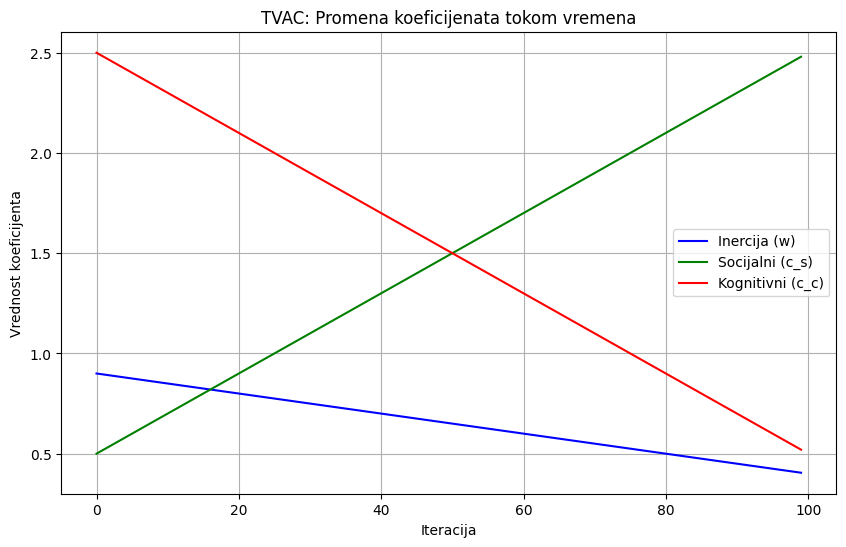

In [41]:
#prikaz grafika 3 komponente kroz vreme u TVAC:

# Broj iteracija
num_iters = 100

# TVAC parametri
w_max, w_min = 0.9, 0.4
c_s_min, c_s_max = 0.5, 2.5
c_c_max, c_c_min = 2.5, 0.5

# Kreiranje liste iteracija
iterations = np.arange(num_iters)

# Računanje vrednosti koeficijenata po iteracijama
c_inertia = w_max - (w_max - w_min) * iterations / num_iters
c_social = c_s_min + (c_s_max - c_s_min) * iterations / num_iters
c_cognitive = c_c_max - (c_c_max - c_c_min) * iterations / num_iters

# Crtanje grafika
plt.figure(figsize=(10,6))
plt.plot(iterations, c_inertia, label="Inercija (w)", color='blue')
plt.plot(iterations, c_social, label="Socijalni (c_s)", color='green')
plt.plot(iterations, c_cognitive, label="Kognitivni (c_c)", color='red')
plt.xlabel("Iteracija")
plt.ylabel("Vrednost koeficijenta")
plt.title("TVAC: Promena koeficijenata tokom vremena")
plt.legend()
plt.grid(True)
plt.show()


In [42]:
def pso_tvac(num_iters: int, swarm_size: int, bounds: np.ndarray, f: callable):
    # Kreiranje roja
    swarm = [Particle(bounds, f, c_inertia=0, c_social=0, c_cognitive=0) for _ in range(swarm_size)]
    
    # Čuvanje istorije za vizualizaciju
    history_positions = []

    for iter in range(num_iters):
        # Dobijamo trenutne TVAC koeficijente
        w, c_s, c_c = tvac_coefficients(iter, num_iters)

        # Update svake čestice
        for p in swarm:
            p.update_velocity(c_inertia=w, c_social=c_s, c_cognitive=c_c)
            p.move(c_inertia=w, c_social=c_s, c_cognitive=c_c)

        # Sačuvamo pozicije za animaciju
        history_positions.append([p.position.copy() for p in swarm])

    # Vraćamo najbolje rešenje i istoriju pozicija
    return Particle.swarm_best_position, Particle.swarm_best_value, history_positions



Najbolja pozicija: [420.96874627 420.96874666]
Vrednost na toj poziciji: 2.5455132345086895e-05
Brzina konvergencije (TVAC PSO): 0.0099


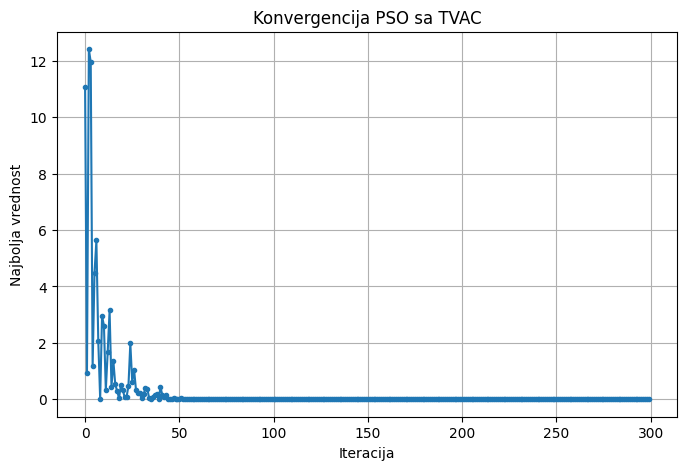

In [72]:
# Definisanje granica za 2D Schwefel
bounds = np.array([[-500, 500], [-500, 500]])

# Pokretanje PSO sa TVAC
best_pos, best_val, history_positions = pso_tvac(num_iters=300, swarm_size=500, bounds=bounds, f=schwefel_2d)

print("Najbolja pozicija:", best_pos)
print("Vrednost na toj poziciji:", best_val)
speed_tvac = convergence_speed(best_values_per_iter)
print(f"Brzina konvergencije (TVAC PSO): {speed_tvac:.4f}")

# Kreiranje niza najboljih vrednosti po iteracijama za grafikon konvergencije
best_values_per_iter = []
for positions in history_positions:
    values = [schwefel_2d(p[0], p[1]) for p in positions]
    best_values_per_iter.append(min(values))

# Grafikon konvergencije
plt.figure(figsize=(8,5))
plt.plot(best_values_per_iter, marker='o', markersize=3)
plt.xlabel("Iteracija")
plt.ylabel("Najbolja vrednost")
plt.title("Konvergencija PSO sa TVAC")
plt.grid(True)
plt.show()


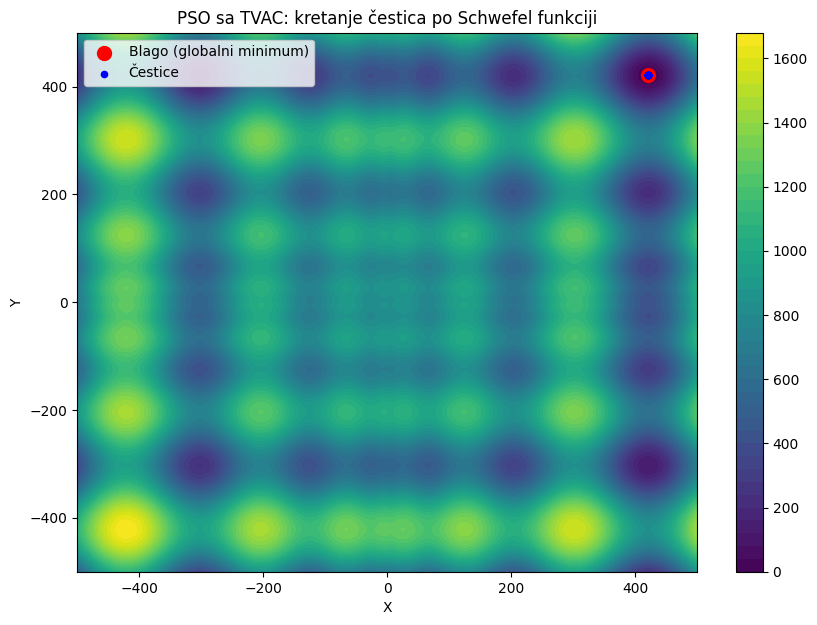

In [44]:
from matplotlib import animation
from IPython.display import HTML


# Kreiranje figure
fig, ax = plt.subplots(figsize=(10,7))

# Konturni plot Schwefel funkcije kao "pustinja"
x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, ax=ax)

# Globalni minimum
ax.scatter(420.9687, 420.9687, color='red', s=100, label='Blago (globalni minimum)')

# Početne pozicije čestica
positions = np.array(history_positions[0])
scat = ax.scatter(positions[:,0], positions[:,1], color='blue', s=20, label='Čestice')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("PSO sa TVAC: kretanje čestica po Schwefel funkciji")
ax.legend()

def init():
    scat.set_offsets(np.array(history_positions[0]))
    return scat,

# Funkcija za update animacije
def update(frame):
    positions = np.array(history_positions[frame])
    scat.set_offsets(positions)
    return scat,

# Kreiranje animacije
ani = animation.FuncAnimation(fig, update, frames=len(history_positions),
                              init_func=init, blit=True, interval=50)

# Prikaz animacije u notebook-u
HTML(ani.to_html5_video())

# Heterogeni roj istraživača (PSO sa TVAC)

U ovom delu uvodimo **heterogeni roj** istraživača, gde različiti tipovi čestica imaju različite strategije kretanja i TVAC parametre.  

## Tipovi istraživača:
- **Adventurer** – voli široko istraživanje, veća inercija, niži kognitivni i socijalni koeficijenti.
- **Aggressive** – fokusiran na globalno najbolje rešenje, manja inercija, veći kognitivni i socijalni koeficijenti.
- **Standard** – balans između istraživanja i eksploatacije.
- **Innovative** – eksperimentiše, povremeni lokalni mutacioni pomaci.

## Koncept:
- Svaka čestica vodi evidenciju svog **ličnog najboljeg rešenja**, a roj prati **globalno najbolje rešenje**.
- **TVAC koeficijenti** (inercija, socijalni, kognitivni) se menjaju tokom iteracija po tipu čestice, omogućavajući različite dinamike kretanja.
- Roj se kreira tako što se kombinuju različiti tipovi čestica sa definisanim brojem svake vrste.
- Čuvamo **istoriju pozicija i TVAC koeficijenata** za svaku vrstu čestice kako bismo mogli vizualizovati kretanje i statistiku.


In [61]:
# BAZNA KLASA: Explorer
class Explorer:
    def __init__(self, dim, bounds, w, c1, c2):
        self.position = np.random.uniform(bounds[:,0], bounds[:,1])
        self.velocity = np.random.uniform(-0.1*(bounds[:,1]-bounds[:,0]), 
                                          0.1*(bounds[:,1]-bounds[:,0]))
        self.best_position = self.position.copy()
        self.best_value = float('inf')
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def update_velocity(self, global_best):
        r1 = np.random.rand(len(self.position))
        r2 = np.random.rand(len(self.position))
        cognitive = self.c1 * r1 * (self.best_position - self.position)
        social = self.c2 * r2 * (global_best - self.position)
        self.velocity = self.w * self.velocity + cognitive + social

    def update_position(self, bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, bounds[:,0], bounds[:,1])

# TIPOVI EXPLORERA
class Adventurer(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.9, c1=1.2, c2=1.2)

class Aggressive(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.4, c1=2.2, c2=2.4)

class Standard(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.7, c1=1.7, c2=1.7)

class Innovative(Explorer):
    def __init__(self, dim, bounds):
        super().__init__(dim, bounds, w=0.6, c1=2.0, c2=1.8)
    def update_position(self, bounds):
        super().update_position(bounds)
        if np.random.rand() < 0.1:
            self.position += np.random.normal(0, 0.1, len(self.position))
            self.position = np.clip(self.position, bounds[:,0], bounds[:,1])


In [62]:
# TVAC po tipu
def tvac_coefficients_by_type(iteration, max_iter):
    coeffs = {}
    coeffs['Adventurer'] = (0.9 - 0.5*iteration/max_iter,
                            1.2 + 0.8*iteration/max_iter,
                            1.2 - 0.7*iteration/max_iter)
    coeffs['Aggressive'] = (0.4 + 0.3*iteration/max_iter,
                            2.2 - 0.7*iteration/max_iter,
                            2.4 - 0.6*iteration/max_iter)
    coeffs['Standard'] = (0.7 - 0.3*iteration/max_iter,
                          1.7 + 1.2*iteration/max_iter,
                          1.7 - 1.2*iteration/max_iter)
    coeffs['Innovative'] = (0.6 - 0.3*iteration/max_iter,
                            2.0 - 1.0*iteration/max_iter,
                            1.8 - 1.0*iteration/max_iter)
    return coeffs

In [63]:
# HETEROGENI PSO
def pso_heterogeneous(num_iters, swarm, bounds, f):
    types = ['Adventurer','Aggressive','Standard','Innovative']
    history_positions_by_type = {t: [] for t in types}
    history_coeffs_by_type = {t: {'w':[], 'c1':[], 'c2':[]} for t in types}

    # Inicijalni global best
    global_best_value = float('inf')
    global_best_position = None
    for p in swarm:
        val = f(p.position[0], p.position[1])
        if val < global_best_value:
            global_best_value = val
            global_best_position = p.position.copy()
        p.best_value = val
        p.best_position = p.position.copy()

    for it in range(num_iters):
        # TVAC parametri po tipu
        coeffs = tvac_coefficients_by_type(it, num_iters)
        for p in swarm:
            t = p.__class__.__name__
            p.w, p.c1, p.c2 = coeffs[t]
            p.update_velocity(global_best_position)
            p.update_position(bounds)
            val = f(p.position[0], p.position[1])

            # Lični best
            if val < p.best_value:
                p.best_value = val
                p.best_position = p.position.copy()
            # Globalni best
            if val < global_best_value:
                global_best_value = val
                global_best_position = p.position.copy()

        # Čuvanje istorije
        for t in types:
            positions_of_type = [p.position.copy() for p in swarm if p.__class__.__name__ == t]
            history_positions_by_type[t].append(positions_of_type)
            ws = np.mean([p.w for p in swarm if p.__class__.__name__ == t])
            c1s = np.mean([p.c1 for p in swarm if p.__class__.__name__ == t])
            c2s = np.mean([p.c2 for p in swarm if p.__class__.__name__ == t])
            history_coeffs_by_type[t]['w'].append(ws)
            history_coeffs_by_type[t]['c1'].append(c1s)
            history_coeffs_by_type[t]['c2'].append(c2s)

    return global_best_position, global_best_value, history_positions_by_type, history_coeffs_by_type


In [65]:
# --- Parametri za test ---
NUM_ADVENTURER = 10
NUM_AGGRESSIVE = 10
NUM_STANDARD = 10
NUM_INNOVATIVE = 10
dim = 2
bounds = np.array([[-500, 500], [-500, 500]])
swarm = ([Adventurer(dim, bounds) for _ in range(NUM_ADVENTURER)] +
         [Aggressive(dim, bounds) for _ in range(NUM_AGGRESSIVE)] +
         [Standard(dim, bounds) for _ in range(NUM_STANDARD)] +
         [Innovative(dim, bounds) for _ in range(NUM_INNOVATIVE)])
num_iters = 300

# Pokretanje
global_best_pos, global_best_val, history_positions, history_coeffs = pso_heterogeneous(
    num_iters, swarm, bounds, schwefel_2d
)

print("Globalni najbolji:", global_best_pos)
print("Vrednost:", global_best_val)


Globalni najbolji: [420.96874606 420.96874644]
Vrednost: 2.5455132345086895e-05


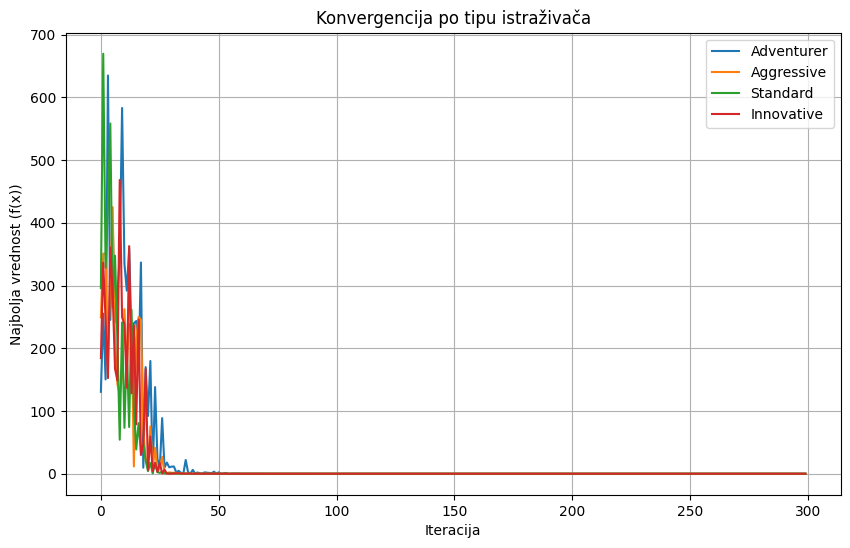

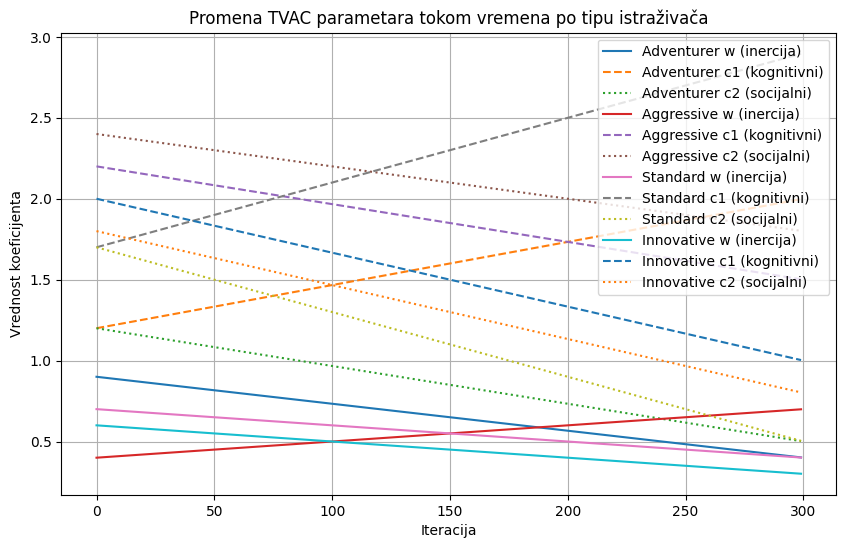

In [66]:
# --- Grafik konvergencije globalnog najboljeg ---
plt.figure(figsize=(10,6))
for t in history_positions.keys():
    best_vals = []
    for pos_list in history_positions[t]:
        # vrednost najboljeg među česticama ovog tipa
        best_val = min([schwefel_2d(p[0], p[1]) for p in pos_list])
        best_vals.append(best_val)
    plt.plot(best_vals, label=f"{t}")
plt.xlabel("Iteracija")
plt.ylabel("Najbolja vrednost (f(x))")
plt.title("Konvergencija po tipu istraživača")
plt.legend()
plt.grid(True)
plt.show()


# --- Grafik TVAC parametara po tipu ---
plt.figure(figsize=(10,6))
for t in history_coeffs.keys():
    iters = np.arange(num_iters)
    plt.plot(iters, history_coeffs[t]['w'], label=f"{t} w (inercija)")
    plt.plot(iters, history_coeffs[t]['c1'], '--', label=f"{t} c1 (kognitivni)")
    plt.plot(iters, history_coeffs[t]['c2'], ':', label=f"{t} c2 (socijalni)")

plt.xlabel("Iteracija")
plt.ylabel("Vrednost koeficijenta")
plt.title("Promena TVAC parametara tokom vremena po tipu istraživača")
plt.legend()
plt.grid(True)
plt.show()


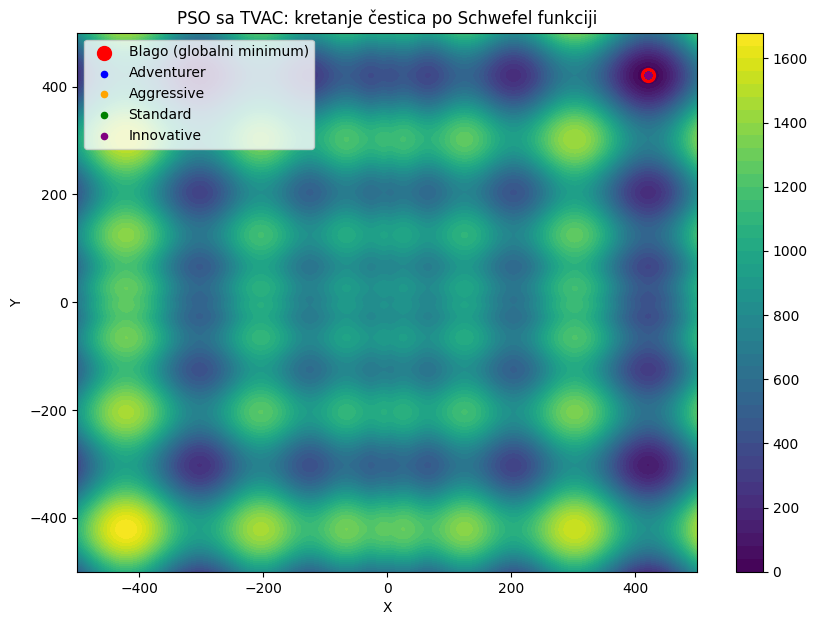

In [67]:
# Kreiranje figure
fig, ax = plt.subplots(figsize=(10,7))

# Konture Schwefel funkcije
x = np.linspace(-500, 500, 400)
y = np.linspace(-500, 500, 400)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, ax=ax)

# Globalni minimum
ax.scatter(420.9687, 420.9687, color='red', s=100, label='Blago (globalni minimum)')

# Boje po tipu
type_colors = {
    'Adventurer': 'blue',
    'Aggressive': 'orange',
    'Standard': 'green',
    'Innovative': 'purple'
}

# Scatter objekti po tipu
scatters = {}
for t, color in type_colors.items():
    positions = np.array(history_positions[t][0])
    scatters[t] = ax.scatter(positions[:,0], positions[:,1], color=color, s=20, label=t)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("PSO sa TVAC: kretanje čestica po Schwefel funkciji")
ax.legend()

# Funkcija za update animacije
def update(frame):
    for t, scat in scatters.items():
        positions = np.array(history_positions[t][frame])
        scat.set_offsets(positions)
    return scatters.values()

# Inicijalizacija (početne pozicije)
def init():
    for t, scat in scatters.items():
        positions = np.array(history_positions[t][0])
        scat.set_offsets(positions)
    return scatters.values()

# Kreiranje animacije
ani = animation.FuncAnimation(fig, update, frames=num_iters,
                              init_func=init, blit=True, interval=50)

# Prikaz u notebook-u
HTML(ani.to_html5_video())


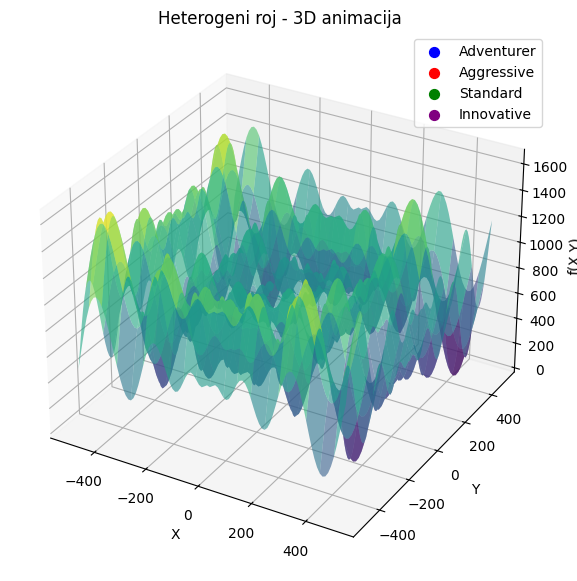

In [69]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Grid za funkciju (površinu)
x = np.linspace(bounds[0,0], bounds[0,1], 100)
y = np.linspace(bounds[1,0], bounds[1,1], 100)
X, Y = np.meshgrid(x, y)
Z = schwefel_2d(X, Y)

# Površina funkcije
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6, rstride=5, cstride=5, edgecolor='none')

# Boje po tipu
colors = {
    'Adventurer': 'blue',
    'Aggressive': 'red',
    'Standard': 'green',
    'Innovative': 'purple'
}

# Scatter objekti po tipu
scatters = {}
for t in history_positions.keys():
    scatters[t] = ax.scatter([], [], [], color=colors[t], s=50, label=t)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X,Y)')
ax.set_title('Heterogeni roj - 3D animacija')
ax.legend()

def init():
    for s in scatters.values():
        s._offsets3d = ([], [], [])
    return scatters.values()

def update(frame):
    for t, s in scatters.items():
        pos = np.array(history_positions[t][frame])
        z = np.array([schwefel_2d(p[0], p[1]) for p in pos])
        if len(pos) > 0:
            s._offsets3d = (pos[:,0], pos[:,1], z)
    return scatters.values()

ani = animation.FuncAnimation(fig, update, frames=len(history_positions['Standard']),
                              init_func=init, blit=False, interval=100)

HTML(ani.to_html5_video())


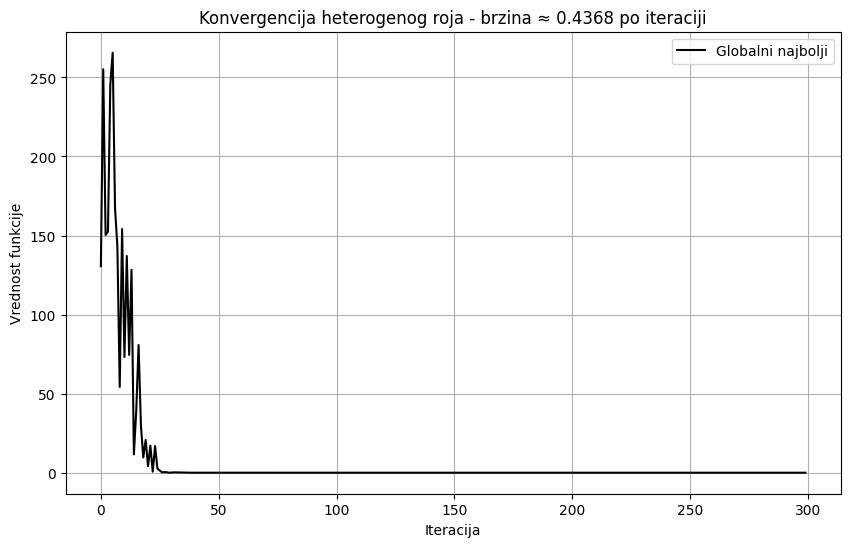

In [70]:
# Izvlačenje globalnih najboljih vrednosti po iteracijama
global_best_history = []
for i in range(num_iters):
    best_val = min(
        [min([schwefel_2d(*p) for p in history_positions[t][i]]) for t in history_positions.keys()]
    )
    global_best_history.append(best_val)

global_best_history = np.array(global_best_history)

# Brzina konvergencije: delta po iteraciji
delta = np.diff(global_best_history)
avg_convergence_rate = -np.mean(delta)  # negativno jer vrednost opada

# Graf globalnog najboljeg kroz iteracije
plt.figure(figsize=(10,6))
plt.plot(global_best_history, color='black', label='Globalni najbolji')
plt.xlabel("Iteracija")
plt.ylabel("Vrednost funkcije")
plt.title(f"Konvergencija heterogenog roja - brzina ≈ {avg_convergence_rate:.4f} po iteraciji")
plt.legend()
plt.grid(True)
plt.show()
